# 2 Image Stitching

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_images(list_of_images):
    fig, ax = plt.subplots(1, len(list_of_images), figsize=(20,20))
    for i, (img,name) in enumerate(list_of_images):
        ax[i].set_title(str(name))
        ax[i].imshow(img);

In [3]:
path_to_data = "stitching_images/"
file_1 = "1Hill.JPG"
file_2 = "2Hill.JPG"
file_3 = "3Hill.JPG"

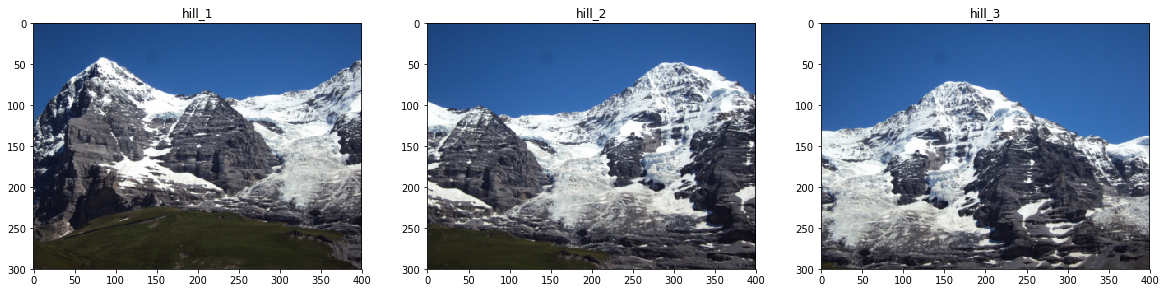

In [4]:
# import imgs
hill_1 = cv2.imread(path_to_data + file_1)
hill_2 = cv2.imread(path_to_data + file_2)
hill_3 = cv2.imread(path_to_data + file_3)

# convert to RGB
hill_1 = cv2.cvtColor(hill_1, cv2.COLOR_BGR2RGB)
hill_2 = cv2.cvtColor(hill_2, cv2.COLOR_BGR2RGB)
hill_3 = cv2.cvtColor(hill_3, cv2.COLOR_BGR2RGB)

# plot images
print_images([(hill_1, "hill_1"), (hill_2, "hill_2"), (hill_3, "hill_3")])

## 2.1 PART 1

### 2.1.1 
Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill. (3 points)

1217
1494


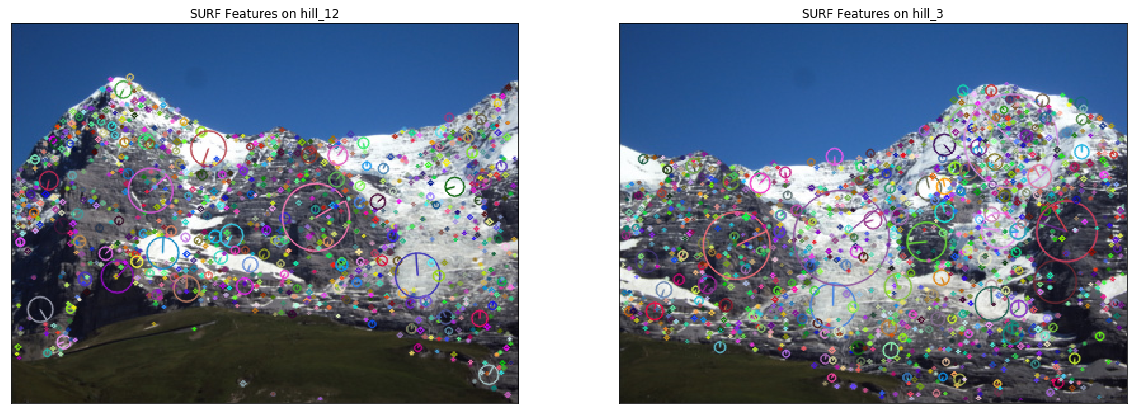

In [5]:
hill_1_cp = hill_1.copy()
hill_2_cp = hill_2.copy()

# sift object 
sift = cv2.xfeatures2d.SIFT_create()

# compute SIFT keypoints & descriptor
keypoints_hill_1, descriptors_hill_1 = sift.detectAndCompute(hill_1, None)
keypoints_hill_2, descriptors_hill_2 = sift.detectAndCompute(hill_2, None)
print(len(keypoints_hill_1))
print(len(keypoints_hill_2))

# draw keypoints on copies
cv2.drawKeypoints(hill_1, keypoints_hill_1,
                  hill_1_cp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill_2, keypoints_hill_2,
                  hill_2_cp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill_1_cp)
plt.title("SURF Features on hill_12"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill_2_cp)
plt.title("SURF Features on hill_3"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.2
Find matching keypoints in two images and display the 20 best pairs. (4 points)

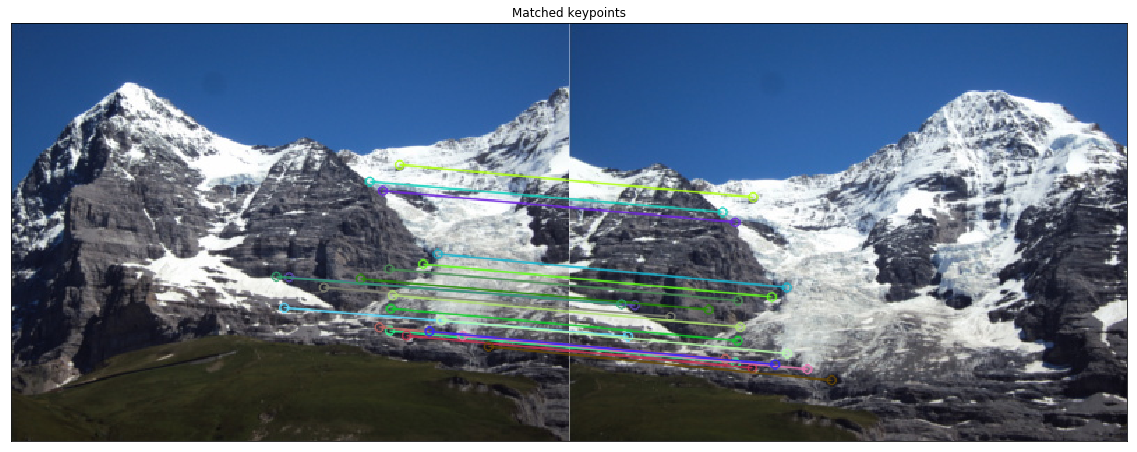

In [6]:
# Match descriptors and keep only best 20
def get_n_best_matches(n, descriptors_1, descriptors_2):
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors_1, descriptors_2)
    return sorted(matches, key = lambda x:x.distance)[:n]

matches = get_n_best_matches(20, descriptors_hill_1, descriptors_hill_2)

# Draw keypoints and plot
match_img = cv2.drawMatches(hill_1, keypoints_hill_1,
                            hill_2, keypoints_hill_2,
                            matches, hill_1, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(match_img)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.3
Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed. (7 points)

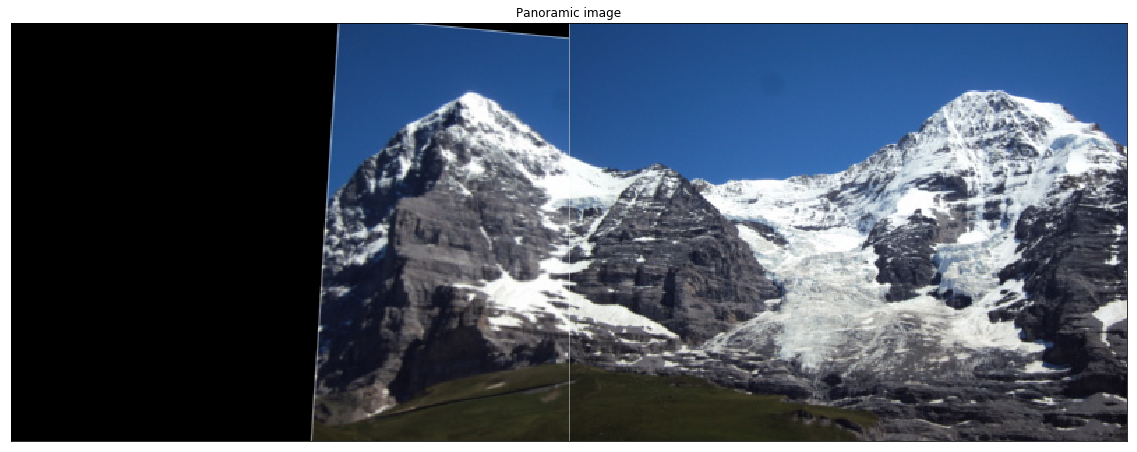

In [7]:
def get_good_matches(ms, kpts_1, kpts_2, img_1):
    # Arrange matching keypoints in two separate lists
    GoodMatches = []
    for i, m in enumerate(ms):
        GoodMatches.append((m.trainIdx, m.queryIdx))

    mp_2 = np.float32([kpts_2[i].pt for (i, __) in GoodMatches])
    mp_1 = np.float32([kpts_1[i].pt for (__, i) in GoodMatches])

    # shift points towards the right
    for i in range(len(mp_2)):
        mp_2[i][0] += img_1.shape[1]
        
    return mp_2, mp_1
    
def get_transformation_ransac(img_1, img_2, mp_1, mp_2):
    # find homography and wrap image accordingly
    H, __ = cv2.findHomography(mp_1, mp_2, cv2.RANSAC, 5)
    img = cv2.warpPerspective(img_1, H, (img_2.shape[1]+img_1.shape[1], img_2.shape[0]))
    img[:,img_1.shape[1]:,:] = img_2
    return img

mpr, mpl = get_good_matches(matches, keypoints_hill_1, keypoints_hill_2, hill_1)
pano = get_transformation_ransac(hill_1, hill_2, mpl, mpr)

plt.figure(figsize=(20,20))
plt.imshow(pano)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.4
Stitch transformed 1Hill and original 2Hill together using pyramid image blending. (8 points)

In [8]:
def get_gaussian_pyramid(img, d):
    cp = img.copy()
    pyramid = [cp]
    for i in range(d):
        cp = cv2.pyrDown(cp)
        pyramid.append(cp)
    return pyramid


def get_laplacian_pyramid(img, d):
    lp = [img[d-1]]
    for i in range(d-1,0,-1):
        hA, wA, cA = img[i-1].shape
        hr = cv2.pyrUp(img[i], dstsize=(wA, hA))
        lp_ = cv2.subtract(img[i-1], hr, cv2.CV_32F)
        lp.append(lp_)
    return lp


def get_transformation_pyramid(A, B, g_size, depth):
    # generate Gaussian pyramid for A and B.
    gp_A, gp_B = get_gaussian_pyramid(A, g_size), get_gaussian_pyramid(B, g_size)

    # generate Laplacian Pyramid for A and B.
    lp_A, lp_B = get_laplacian_pyramid(gp_A, depth), get_laplacian_pyramid(gp_B, depth)

    # Stack images together at each Laplacian Pyramid level.
    LP = []
    for l_a,l_b in zip(lp_A,lp_B):
        lp_ = np.hstack((l_a,l_b))
        LP.append(lp_)

    # Blend and reconstruct the final image.
    rs_mask = LP[0]
    for i in range(1,depth):
        h, w, c = LP[i].shape
        rs_mask = cv2.pyrUp(rs_mask, dstsize=(w, h))
        rs_mask = cv2.add(rs_mask, LP[i])
    
    return rs_mask

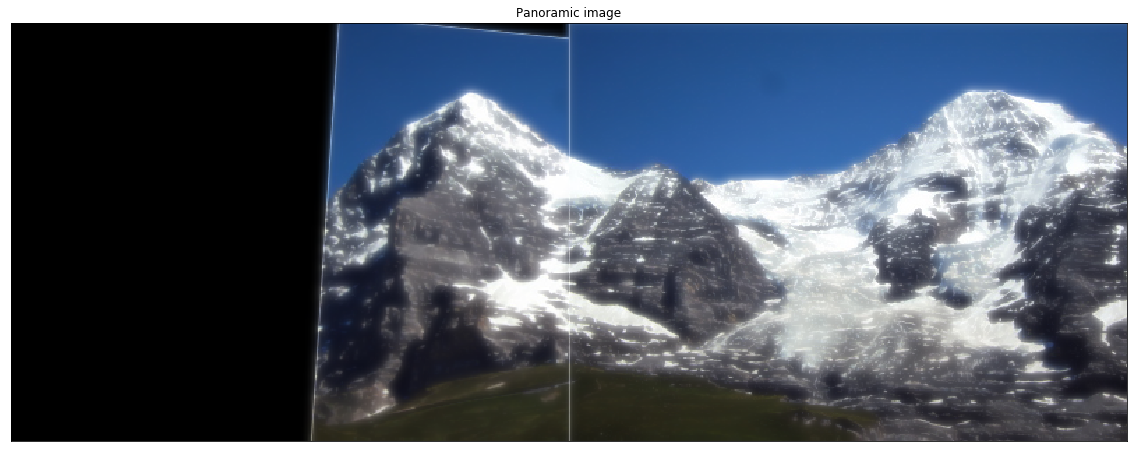

In [9]:
img_left = pano[:, :int(pano.shape[1]/2)]
hill_12 = get_transformation_pyramid(img_left, hill_2, 255 ,3)


plt.figure(figsize=(20,20))
plt.imshow(hill_12)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.1 PART 2

### 2.1.1
Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill. (3 points)

1165
876


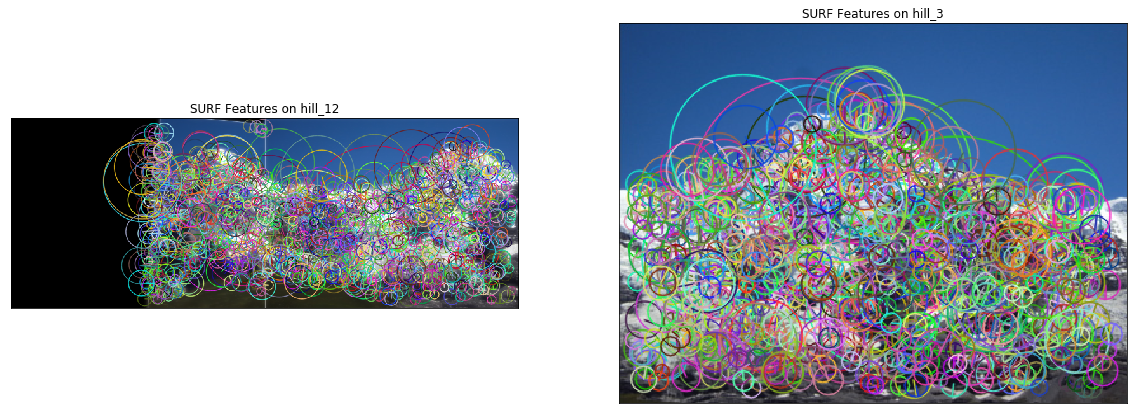

In [10]:
hill_12_cp = hill_12.copy()
hill_3_cp = hill_3.copy()

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# get keypoitns and descriptors
keypoints_hill_12, descriptors_hill_12 = surf.detectAndCompute(hill_12, None)
keypoints_hill_3, descriptors_hill_3 = surf.detectAndCompute(hill_3, None)
print(len(keypoints_hill_12))
print(len(keypoints_hill_3))

# draw keypoints on copies
cv2.drawKeypoints(hill_12, keypoints_hill_12,
                  hill_12_cp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill_3, keypoints_hill_3,
                  hill_3_cp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill_12_cp)
plt.title("SURF Features on hill_12"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill_3_cp)
plt.title("SURF Features on hill_3"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.2 
Find matching keypoints in two images and display the 20 best pairs. (4 points)

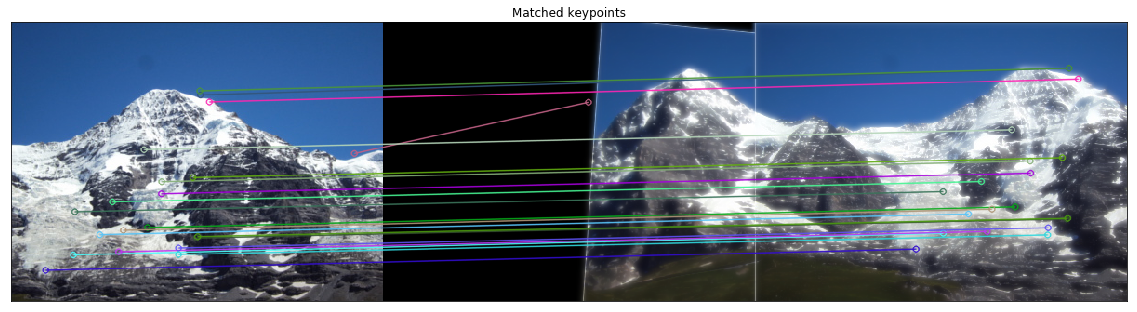

In [11]:
# get 20 best matches
matches = get_n_best_matches(20, descriptors_hill_3, descriptors_hill_12)

# Draw keypoints and plot
match_img = cv2.drawMatches(hill_3, keypoints_hill_3,
                            hill_12, keypoints_hill_12,
                            matches, hill_12, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(match_img)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.3
Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed. (7 points)

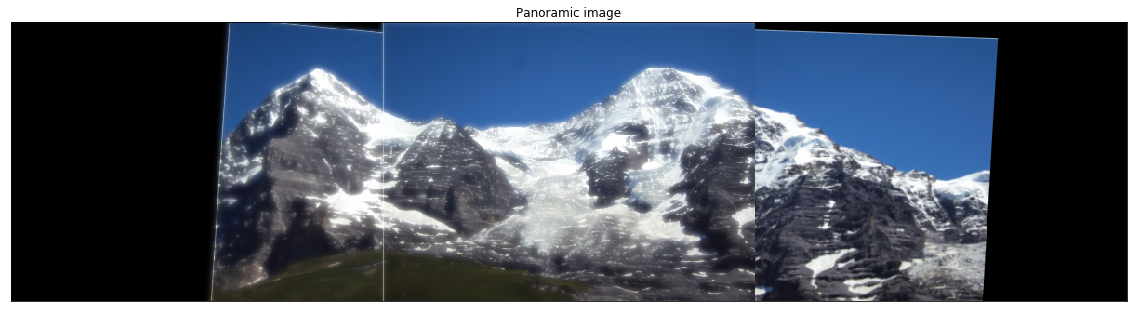

In [12]:
def get_good_matches(ms, kpts_1, kpts_2, img_1, img_2):
    # Arrange matching keypoints in two separate lists
    GoodMatches = []
    for i, m in enumerate(ms):
        GoodMatches.append((m.trainIdx, m.queryIdx))
        
    mp_2 = np.float32([kpts_2[i].pt for (__, i) in GoodMatches])
    mp_1 = np.float32([kpts_1[i].pt for (i, __) in GoodMatches])
    
    # shift points towards the right
    for i in range(len(mp_2)):
        mp_2[i][0] += img_2.shape[1] + img_1.shape[1]
    return mp_2, mp_1
    
def get_transformation_ransac(img_1, img_2, mp_1, mp_2):
    # find homography and wrap image accordingly
    H, __ = cv2.findHomography(mp_1, mp_2, cv2.RANSAC, 5)
    img = cv2.warpPerspective(img_2, H, (img_1.shape[1]+img_2.shape[1], img_1.shape[0]))
    img[:,:img_1.shape[1],:] = img_1
    return img

mpr, mpl = get_good_matches(matches, keypoints_hill_12, keypoints_hill_3, hill_12, hill_3)
pano_all = get_transformation_ransac(hill_12, hill_3, mpl, mpr)

plt.figure(figsize=(20,20))
plt.imshow(pano_all)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.4
Stitch transformed 3Hill and 12Hill together and apply linear image blending. (4 points)

In [13]:
# Not Completed

## 2.2 Reasoning Questions

### 2.2.1
**What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. (4 points)**

SURF (Speeded-Up Robust Features) computes faster than SIFT. There are 2 main reason for that: the number of iterations required and the type of filters used in each techniques to approximate integral operations. SURF uses box filter while SIFT uses several gaussian filters.

The number of keypoint is much greater of SIFT. There are 1217 and 1494 for SIFT while SURF created 1165 and 876. As for the densities, the ploted images show clearly that SIFT has a much higher density. As a result, the SURF technique is not as robust than SIFT. Therefore, speed is a trade-off for robustness.

### 2.2.2
**Discuss at least two pros and cons of pyramid and linear blending tech- niques. When should one prefer pyramid blending over linear blending? (4 points)**

_FREQUENCY_

Linear blending does not performs well on all frequencies (cons). On the otherhand, pyramid does much better on the whole range of frequency (pros).

_COMPUTATIONS_

Linear blending is really easy to compute (pros) while the pyramid technique requires much more computations (cons).

### 2.2.3
**What would happen if a random subset of pairs of matching keypoints is used for finding homography? (2 points)**

The result will not look well stitched. This is because the rotation and orientation change (perspective) will not be calculated properly. We can observe this in 2.1.3 above on the jonction on the RHS of the image.

### 2.2.4
**Discuss the relationship between the number of pairs of matching key- points used for finding homography and the accuracy of inferred homog- raphy. (2 points)**

The more correct pair you have the more likely you image will be well stitched. The problem is that we often have wrong pairs which introduce errors and decreace the accuracy of the homography.